In [1]:
import torch
import mmcv
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot
import os
import numpy as np

/home/zhangzr/anaconda3/envs/Fault_Recong/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = '/home/zhangzr/Fault_Recong/mmsegmentation/output/swin-base-patch4-window7_upernet_8xb2-160k_fault_2Dfault_0519_force3chan-256x256/swin-base-patch4-window7_upernet_8xb2-160k_fault_2Dfault_0519_force3chan-256x256.py'
checkpoint_file = '/home/zhangzr/Fault_Recong/mmsegmentation/output/swin-base-patch4-window7_upernet_8xb2-160k_fault_2Dfault_0519_force3chan-256x256/Best_Dice_79.pth'

In [3]:
# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda:1')
# model = init_model(config_file, checkpoint_file, device='cpu')

/home/zhangzr/Fault_Recong/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/zhangzr/Fault_Recong/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /home/zhangzr/Fault_Recong/mmsegmentation/output/swin-base-patch4-window7_upernet_8xb2-160k_fault_2Dfault_0519_force3chan-256x256/Best_Dice_79.pth


In [8]:
# test a single image
root_dir = '/home/zhangzr/Fault_Recong/Fault_data/2Dfault_0519_256/converted/val/image'
idx = '1956_270'
convert_25d = False
force_3_chan = True
if convert_25d:
    img_cur = np.load(os.path.join(root_dir, f'{idx}.npy'))
    img_prev = np.load(os.path.join(root_dir, f'{max(idx-5,0)}.npy'))
    img_future = np.load(os.path.join(root_dir, f'{min(idx+5,127)}.npy'))
    img_input = np.stack([img_prev, img_cur, img_future], axis=2)
elif force_3_chan:
    img_cur = np.load(os.path.join(root_dir, f'{idx}.npy'))
    img_input = np.stack([img_cur, img_cur, img_cur], axis=2)
else:
    img_cur = np.load(os.path.join(root_dir, f'{idx}.npy'))
    img_input = img_cur
    
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)
result = inference_model(model, img_input)
pred = result.pred_sem_seg.data.detach().cpu().squeeze(0).numpy()
# print(pred)
ann = mmcv.imread(os.path.join(root_dir.replace('image', 'ann'), f'{idx}.png'), flag='unchanged')

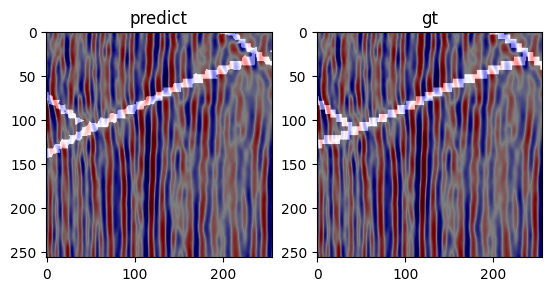

In [9]:
# show the results
# vis_result = show_result_pyplot(model, img, result)
# plt.imshow(mmcv.bgr2rgb(vis_result))
plt.subplot(1,2,1)
plt.title('predict')
plt.imshow(img_cur, cmap='seismic')
plt.imshow(pred, cmap='gray', alpha=0.5)
plt.subplot(1,2,2)
plt.title('gt')
plt.imshow(img_cur, cmap='seismic')
plt.imshow(ann, cmap='gray', alpha=0.5)